# Global Wheat Head Detection EDA

This notebook contains data preprocessing and data exploration for the wheat head dataset provided by the University of Saskatchewan: [available here](https://www.kaggle.com/c/global-wheat-detection). The primary purpose of this notebook is to convert the train.csv file into a usable format for the script in this repo that generates .tfrecord files, as well as analyzing the image data and the boundary box data to further model configuration.

In [9]:
import numpy as np 
import pandas as pd
import glob
import os
import sys
import re
import io
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
from PIL import Image

In [10]:
INPUT_PATH = "./global-wheat-detection"

IMG_DIR = os.path.join(INPUT_PATH, "train")

train_df = pd.read_csv(os.path.join(INPUT_PATH, "train.csv"))

train_df.head()

,image_id,width,height,bbox,source
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1


# DataFrame Preprocessing

In order to write TFRecord files, there are a few preprocessing steps to prepare the DataFrame into a usable format. The most important step is to transform the boundary box data from a string of the form: [xmin, ymin, width, height] to individual features of xmin, xmax, ymin, ymax. When creating the TFRecord files, the boundary boxes for each image will be passed as a list of all xmin values, a list of all xmax values, a list of all ymin values, and a list of all ymax values.

I also have assigned an integer class label as well as a string class label to each boundary box. Obviously this is trivial in this case as there is only one class, but if the training images contained many different kinds of objects this would be important. The only thing that is important to note here is that when generating class labels, labels MUST start at 1. 0 is a placeholder index.

In [11]:
DIGIT_MATCH = "([\d]+[\.]*[\d]*)"

def coord_extract(row, digit_match = DIGIT_MATCH):
    
    digits = re.findall(digit_match, row.bbox)
    
    if digits:
        
        return([int(float(digits[0])), int(float(digits[0]) + float(digits[2])), 
                  int(float(digits[1])), int(float(digits[1]) + float(digits[3]))])
        
    else:
        
        return([np.nan, np.nan, np.nan, np.nan])
    
train_df[["xmin", "xmax", "ymin", "ymax"]] = train_df.apply(lambda x: coord_extract(x), axis = 1,
                                                                  result_type = "expand")

In [12]:
train_df["class"] = 1

train_df["class_text"] = "wheat-head"

def add_jpg(x):
    
    return(x + ".jpg")

train_df["filename"] = train_df.image_id.apply(lambda x: add_jpg(x))

train_df = train_df.drop(columns = ["bbox", "image_id"])

In [13]:
train_df.head()

,width,height,source,xmin,xmax,ymin,ymax,class,class_text,filename
0,1024,1024,usask_1,834,890,222,258,1,wheat-head,b6ab77fd7.jpg
1,1024,1024,usask_1,226,356,548,606,1,wheat-head,b6ab77fd7.jpg
2,1024,1024,usask_1,377,451,504,664,1,wheat-head,b6ab77fd7.jpg
3,1024,1024,usask_1,834,943,95,202,1,wheat-head,b6ab77fd7.jpg
4,1024,1024,usask_1,26,150,144,261,1,wheat-head,b6ab77fd7.jpg


# EDA
There are several things to look into before generating train, eval, and test TFRecord files. There is of course basic image EDA (number of images, image dimensions, etc.) and then there are some boundary box specific items that are helpful for writing the .config file for the TF object detection API. It is helpful to know the distribution of the size of the boundary boxes, as well as the distribution of the number of boundary boxes per image. This will help to make informed choices for several of the values in the .config file, such as:

- max_total_detections
- max_detections_per_class
- grid_anchor_generator
    - scales, aspect_ratio
    

To do this, I will examine the following fields:

- Number of images
- Height / width of images
- Average bbox size 
- Max bbox size 
- Min bbox size 
- Average # of bboxes/image
- Max # of bboxes / image
- Min # of bboxes / image
- Data source Distribution

In [14]:
#num images
print("{} unique images\n".format(train_df.filename.nunique()))

#image width
print("Image width counts")
print(train_df.width.value_counts())
print()

#image height
print("Image height counts")
print(train_df.height.value_counts())

3373 unique images

Image width counts
1024    147793
Name: width, dtype: int64

Image height counts
1024    147793
Name: height, dtype: int64


## Boundary Box Size Visualization

It's important to have an idea of the size distribution of boundary boxes... This information will be helpful when putting together the .config file for the TF object detection API later. It will also give us a general idea of what the boundary boxes look like, and whether any of the boxes are illegitimate. 

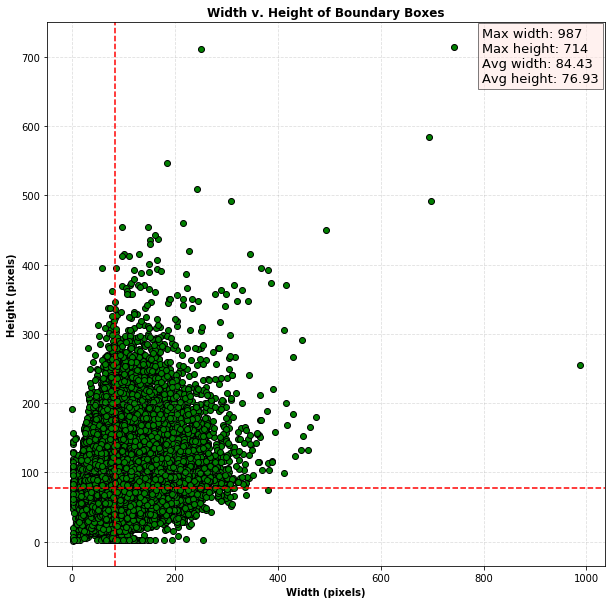

In [15]:
bbox_width, bbox_height = train_df.xmax.values - train_df.xmin.values, train_df.ymax.values - train_df.ymin.values

mean_bbox_width, mean_bbox_height = bbox_width.mean(), bbox_height.mean()

max_bbox_width, max_bbox_height = bbox_width.max(), bbox_height.max()

min_bbox_width, min_bbox_height = bbox_width.min(), bbox_height.min()

fig, ax = plt.subplots(1, figsize = (10, 10))

ax.scatter(bbox_width, bbox_height, color = "green", edgecolor = "black")

ax.xaxis.grid(True, linestyle='--', which='major',
                   color='grey', alpha=.25)

ax.yaxis.grid(True, linestyle='--', which='major',
                   color='grey', alpha=.25)

ax.axhline(mean_bbox_height, ls = "--", c = "r", xmin = 0., xmax = 1)

ax.axvline(mean_bbox_width, ls = "--", c = "r", ymin = 0, ymax = 1)

ax.set_title("Width v. Height of Boundary Boxes", weight = "bold")

ax.set_xlabel("Width (pixels)", weight = "bold")

ax.set_ylabel("Height (pixels)", weight = "bold")

ax_str = "\n".join([
    f"Max width: {max_bbox_width}",
    f"Max height: {max_bbox_height}",
    "Avg width: %.2f" % mean_bbox_width,
    "Avg height: %.2f" % mean_bbox_height
])

text_box = {

        "boxstyle" : "square",

        "facecolor" : "mistyrose",

        "edgecolor" : "k",

        "alpha" : 0.5
    }

ax.text(0.78, 0.89, ax_str, transform = ax.transAxes, fontsize = 13, 
    bbox = text_box);

From looking at this plot, there are a couple of boxes with concerning dimensions; the widest and tallest boundary boxes in particular. The widest box is almost the same width as the entire image, which would imply an extreme close-up of a wheat head. Let's hope that is the case.

In [16]:
## utility function for plotting images / boundary boxes

def plot_bboxes(filenames, n_col, train_df, img_dir = IMG_DIR):
    
    if len(filenames) <= n_col:
        
        fig, ax = plt.subplots(1, len(filenames), figsize=(16, 8))
        
        single_indice = True
        
    else:
        
        n_row = max(len(filenames) // n_col, n_col)
        
        fig, ax = plt.subplots(n_row, n_col, figsize = (16, 8))
        
        single_indice = False
    
    for i, file in enumerate(filenames):
        
        img_df = train_df[train_df.filename == file].reset_index(drop = True)
        
        path = os.path.join(img_dir, file)
        
        img = cv2.imread(path)
        
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        for _, row in img_df.iterrows():
        
            cv2.rectangle(img, (row.xmin, row.ymin), (row.xmax, row.ymax), (255, 0, 0), 2)

        if len(filenames) > 1 and single_indice:
        
            ax[i].set_axis_off()

            ax[i].imshow(img)

            ax[i].set_title(file)
            
        elif len(filenames) > 1 and not single_indice:
            
            r, c = i // n_row, i % n_row
            
            ax[r, c].set_axis_off()
            
            ax[r, c].imshow(img)
            
            ax[r, c].set_title(file)
            
        else:
            
            ax.set_axis_off()

            ax.imshow(img)

            ax.set_title(file)

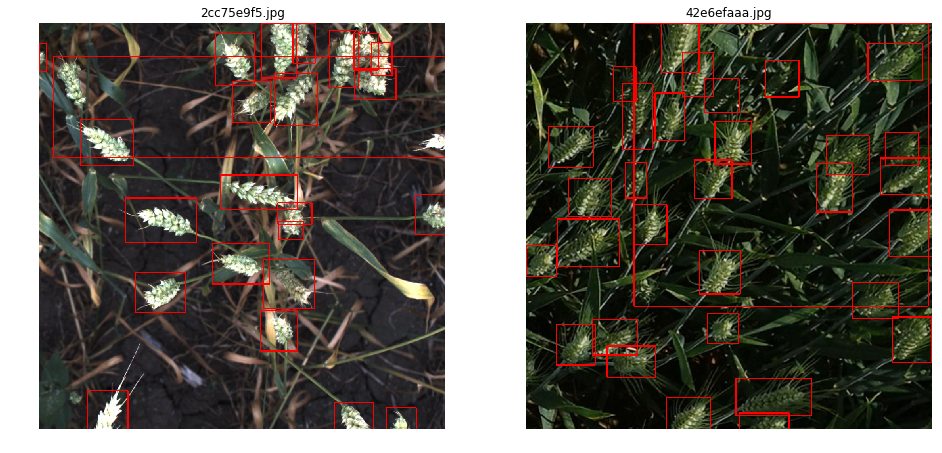

In [17]:
widest = train_df[train_df.xmax - train_df.xmin == max_bbox_width].filename.max()

tallest = train_df[train_df.ymax - train_df.ymin == max_bbox_height].filename.max()

plot_bboxes([widest, tallest], 2, train_df)

As you can see, two of these boxes are not like the others. It's hard to imagine these weren't labeling mistakes (or perhaps an error in the regex extraction)... I was hoping these were just going to be really really zoomed in, but unfortunately this probably means I need to look in to all of the larger size boxes because these will need to be dropped before modeling. Or at least manually adjusted, in the top-left image there is a wheat head in the super wide box, it's just only in the top left corner. I have no idea what's going on in that top right image.

First things first, I'm going to read back in the unprocessed dataset and check if the error is on my end.

In [18]:
widest_idx = train_df[train_df.xmax - train_df.xmin == max_bbox_width].index[0]

tallest_idx = train_df[train_df.ymax - train_df.ymin == max_bbox_height].index[0]

unprocessed = pd.read_csv(os.path.join(INPUT_PATH, "train.csv"))

extrema = pd.concat([unprocessed.iloc[widest_idx], unprocessed.iloc[tallest_idx]], axis = 0)

del unprocessed

extrema

image_id                     2cc75e9f5
width                             1024
height                            1024
bbox        [37.0, 84.0, 987.0, 255.0]
source                         usask_1
image_id                     42e6efaaa
width                             1024
height                            1024
bbox        [272.0, 0.0, 742.0, 714.0]
source                       arvalis_3
dtype: object

Well, the error is not on my end so these will need to be dealt with. Now I need to look deeper into just how many of these giant boxes there are and if all of them are illegitimate or if there truly just some massive wheat-heads out there.

In [19]:
oversized_boxes = train_df[(train_df.xmax - train_df.xmin > 500) |
                          (train_df.ymax - train_df.ymin > 500)].filename.values

print(f"There are {oversized_boxes.shape[0]} boxes over the 500 threshold")

There are 7 boxes over the 500 threshold


NOTE: I'm going to plot them in pairs of two, it's too hard to make out the individual boundary boxes otherwise. 

In [20]:
print(oversized_boxes)

['a1321ca95.jpg' '2cc75e9f5.jpg' '42e6efaaa.jpg' 'd7a02151d.jpg'
 'd067ac2b1.jpg' 'b8ddb6c73.jpg' 'd60e832a5.jpg']


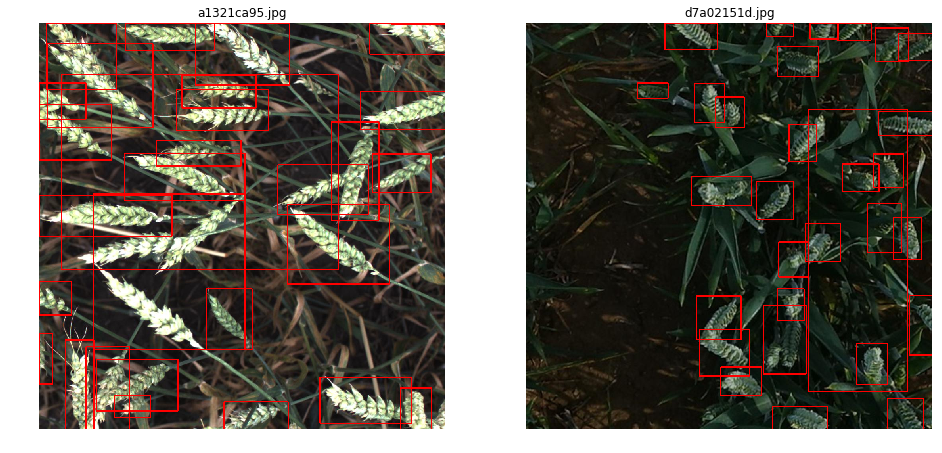

In [21]:
plot_bboxes(['a1321ca95.jpg', 'd7a02151d.jpg'], 2, train_df)

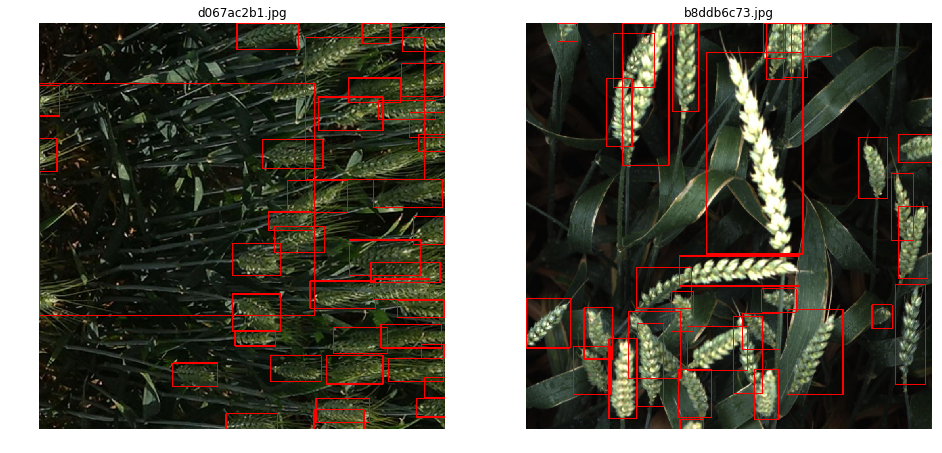

In [22]:
plot_bboxes(["d067ac2b1.jpg", 'b8ddb6c73.jpg'], 2, train_df)

Well, it appears that one of them is a giant wheat head and the rest are inexplicable. The tricky bit is that now I know these super large boxes are not all erroneous: at least one of them is completely legitimate and thus blindly removing them is not an option (Blindly removing anything should never be an option). Obviously I can't go through all $147,000$ boundary boxes and this brief investigation does not give me an over abundance of confidence in the quality of the boxes but I will remove the few I know are invalid (or adjust them) and take steps during model training to account for noise. 

I'm also noticing that these images look starkly different from each other... I assume this has to do with the source of the image. It will be important to maintain the source distribution in the training and validation sets. 

In [23]:
oversized_boxes = train_df[(train_df.xmax - train_df.xmin > 500) |
                          (train_df.ymax - train_df.ymin > 500)]

oversized_boxes = oversized_boxes.drop(128028, axis = 0) #this is the one that was a legitimate wheat head

train_df = train_df.drop(oversized_boxes.index, axis = 0).reset_index(drop = True)

## Boundary Box Frequency Visualization

As mentioned above, knowing the distribution of the total number of boundary boxes per image is important. There are several parameter values this will effect, such as the number of regions proposed and the max number of objects detected per image. 

In [24]:
grouped = train_df.groupby("filename")

n_boxes = np.array([len(grouped.get_group(g)) for g in grouped.groups])

mean_boxes, max_boxes, min_boxes = n_boxes.mean(), n_boxes.max(), n_boxes.min()

print(f"The largest number of boxes in a single image is {max_boxes}")

The largest number of boxes in a single image is 116


/Users/atticussoane/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


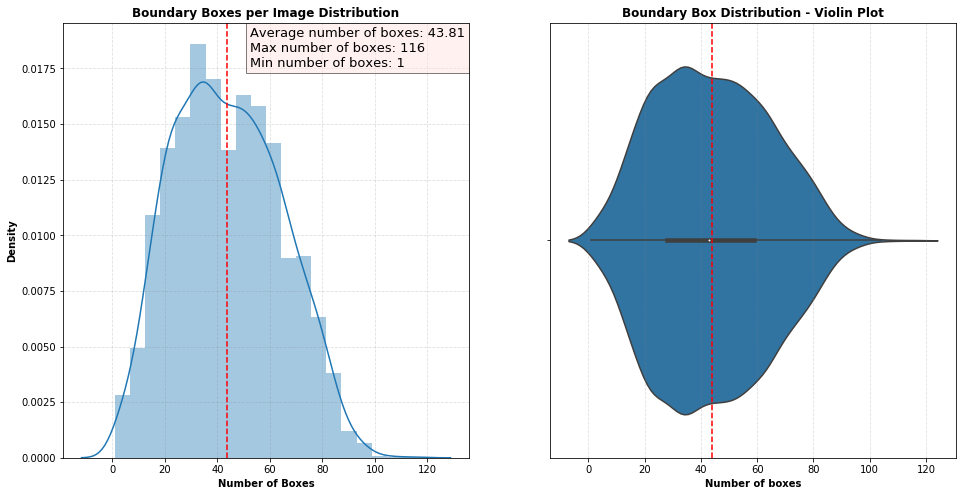

In [25]:
fig, ax = plt.subplots(1, 2, figsize = (16, 8))

sns.distplot(n_boxes, bins = 20, ax = ax[0])

ax[0].xaxis.grid(True, linestyle='--', which='major',
                   color='grey', alpha=.25)

ax[0].yaxis.grid(True, linestyle='--', which='major',
                   color='grey', alpha=.25)

ax[0].axvline(mean_boxes, ls = "--", c = "r", ymin = 0, ymax = 1)

ax[0].set_title("Boundary Boxes per Image Distribution", weight = "bold")

ax[0].set_ylabel("Density", weight = "bold")

ax[0].set_xlabel("Number of Boxes", weight = "bold")

ax00_str = "\n".join([
    "Average number of boxes: %.2f" % mean_boxes,
    f"Max number of boxes: {max_boxes}",
    f"Min number of boxes: {min_boxes}"
])

text_box = {

        "boxstyle" : "square",

        "facecolor" : "mistyrose",

        "edgecolor" : "k",

        "alpha" : 0.5
    }

ax[0].text(0.46, 0.90, ax00_str, transform = ax[0].transAxes, fontsize = 13, 
    bbox = text_box)

sns.violinplot(x = n_boxes, ax = ax[1])

ax[1].xaxis.grid(True, linestyle='--', which='major',
                   color='grey', alpha=.25)

ax[1].axvline(mean_boxes, ls = "--", c = "r", ymin = 0, ymax = 1)

ax[1].set_title("Boundary Box Distribution - Violin Plot", weight = "bold")

ax[1].set_xlabel("Number of boxes", weight = "bold");

According to this analysis, the maximum boxes in an image is $116$. I will need that number going forward. The minimum number is not as important, but it's useful to see the distribution. Now I'd like to check if there are training images with no boxes: Images in the train folder that do not appear in the bbox DataFrame. 

In [26]:
all_imgs = glob.glob(os.path.join(IMG_DIR, "*.jpg"))

print(f"There are {len(all_imgs)} unique images in the train directory, and there are {len(n_boxes)} in the DataFrame.")

There are 3422 unique images in the train directory, and there are 3373 in the DataFrame.


Right, so there are 49 images in the trains set that do not have boundary boxes. I'd be interested to look at a couple of those, but first I'd like to take a look at the images with the most and least boxes.

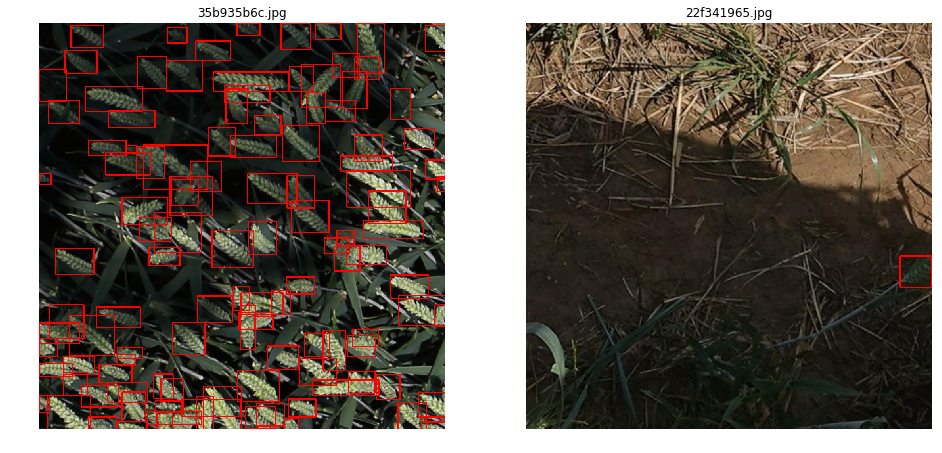

In [27]:
most_frequent, least_frequent = train_df.filename.value_counts().index[0], train_df.filename.value_counts().index[-1]

plot_bboxes([most_frequent, least_frequent], 2, train_df)

Those both look good. Moving along.

## Source Distribution Visualization
As mentioned above, there are a number of unique image sources. They clearly do not all look the same, and thus it will be important to ensure that each image source is appropriately represented in the training and validation sets. I also want to look at the box distribution within each source to see if it varies by source.

In [28]:
from collections import Counter

source_count = Counter(train_df.groupby("filename").source.max().tolist())

In [29]:
source_labels, source_values = list(source_count.keys()), list(source_count.values())

source_dists = {}

for source in source_labels:
    
    source_dists[source] = train_df[train_df.source == source].filename.value_counts().values

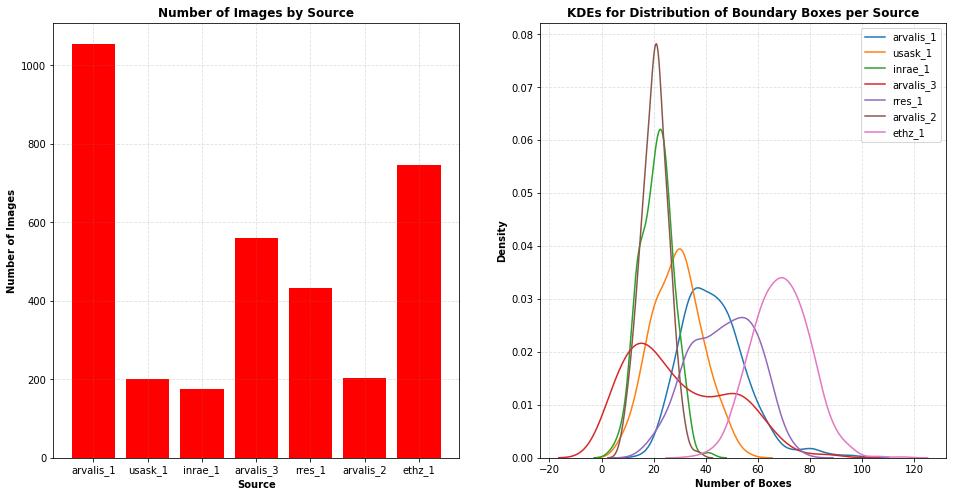

In [30]:
fig, ax = plt.subplots(1, 2, figsize = (16, 8))

ax[0].bar(x = source_labels, height = source_values, color = "r")

ax[0].xaxis.grid(True, linestyle='--', which='major',
                   color='grey', alpha=.25)

ax[0].yaxis.grid(True, linestyle='--', which='major',
                   color='grey', alpha=.25)

ax[0].set_title("Number of Images by Source", weight = "bold")

ax[0].set_ylabel("Number of Images", weight = "bold")

ax[0].set_xlabel("Source", weight = "bold")

for source in source_dists:
    
    sns.distplot(source_dists[source], hist = False, label = source, ax = ax[1])

ax[1].xaxis.grid(True, linestyle='--', which='major',
                   color='grey', alpha=.25)

ax[1].yaxis.grid(True, linestyle='--', which='major',
                   color='grey', alpha=.25)

ax[1].set_title("KDEs for Distribution of Boundary Boxes per Source", weight = "bold")

ax[1].set_xlabel("Number of Boxes", weight = "bold")

ax[1].set_ylabel("Density", weight = "bold");

Now the KDE plot above is Kernel Density Estimates for the distribution of the number of boxes per image per source, obviously there are no images with negative amount of boundary boxes: These are merely distribution estimates. What is interesting is that they are not at all similar: save 2, the sources have unique distributions. This confirms that it will be vital to maintain the source distribution in both training and validation sets.

I'm going to write a new copy of the dataframe, which will be passed to the .tfrecord script.

In [32]:
train_df.to_csv("./global-wheat-detection/pre_tf.csv.gz", index = False, compression = "gzip")